# LendingClub: Predict Loan Charge-Offs 


## 1. Project Description <a id = '1'></a>

In this project, we analyze the loan data of LendingClub for 2 years.  The data explores the demographic dimensions of personal loans and loan status (fully paid/ charged off), which is available on their website once you create an account.

Our goal is to identify the risk of unsecured personal loans. Specifically, a machine learning model will be developed to predict the probability of full payment and charge off. which will help in investors identifying which loans to invest in 

## 2. Import Libraries <a id = '2'></a>

In [66]:
import glob
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


sns.set(style = 'ticks')
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 122


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_auc_score, roc_curve,precision_score, recall_score, precision_recall_curve


## 3. Data Collection and Pre-Processing <a id = '3'></a>

Before loading the datasets into the notebook, unformatted rows of texts in each dataset have been removed. 

In [91]:
filenames = glob.glob("*.csv.gz")

DataFrame = []
for f in filenames:
    
   DataFrame.append(pd.read_csv(f,compression = 'gzip'))

df = pd.concat(DataFrame)

c:\users\avina\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\avina\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (99) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,id,funded_amnt,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,75910406,8400,36 months,9.75%,270.06,B3,RV Tech,2 years,MORTGAGE,66000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,75768614,12000,36 months,7.89%,375.43,A5,facility manager,3 years,OWN,45000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,75650131,28000,36 months,7.39%,869.57,A4,graphic designer ii,1 year,RENT,60000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,76084025,10000,36 months,13.67%,340.18,C3,Cantor,10+ years,RENT,70000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,76003313,20000,36 months,11.99%,664.20,C1,rn case manager,10+ years,MORTGAGE,49000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877986 entries, 0 to 118647
Columns: 109 entries, id to sec_app_mths_since_last_major_derog
dtypes: float64(47), int64(42), object(20)
memory usage: 736.8+ MB


The original data has more than 0.8 million records and 109 features.

### 3.1 Assumptions<a id = '3.1'></a>

`Assumption 1`

In [5]:
df['loan_status'].value_counts()

Current               503359
Fully Paid            264241
Charged Off            81570
Late (31-120 days)     16259
In Grace Period         8052
Late (16-30 days)       4505
Name: loan_status, dtype: int64

**Modeling**: "loan_status" is the `target variable`. Because we are predicting whether the loan would be paid off, we just keep loans with status `'Fully paid'` and `'Charged Off'` and considering 'Late (31-120)' and 'Late (16-30 days)' as as bad loans as well 


`Assumption 2`

Next, Based on the provided data dictionairy, dropping features with posterior knowledge about our target variable - loan status ie these would not be available unless the loan is processed. This is also known as data leakage. Leakage happens when it is attempted to build a model with data that is not available during prediction. This causes incorrect modeling to happen as they will not be generalizable. and by checking the NAN values in the data Here we are going to drop out columns with missing value ratio greater than 0.3

In [92]:
nan_mean = df.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values(ascending=False)
nan_mean.head(30)

drop_list_columns = sorted(list(nan_mean[nan_mean>0.3].index))
drop_list_columns
print(len(drop_list_columns))

df.drop(labels = drop_list_columns,axis=1,inplace = True)
df.shape

21


(877986, 88)

In [93]:
drop_cols = ['id','zip_code', 'last_credit_pull_d', 'last_fico_range_high','last_fico_range_low',
'collections_12_mths_ex_med','bc_open_to_buy', 'bc_util','mths_since_recent_inq',
'num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 
'num_rev_tl_bal_gt_0', 'num_sats','total_cu_tl','inq_fi','all_util','num_tl_30dpd','pct_tl_nvr_dlq','tax_liens',
'total_il_high_credit_limit','open_rv_12m','open_rv_24m','mo_sin_old_rev_tl_op','total_rev_hi_lim','il_util',
'open_acc_6m','open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','mo_sin_old_il_acct',
'inq_last_6mths','out_prncp','inq_last_12m','acc_open_past_24mths','max_bal_bc','earliest_cr_line']


df.drop(columns = drop_cols,inplace = True)
df.shape

(877986, 45)

In [94]:
# selecting data as per loan status 

df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Late (31-120 days)','Late (16-30 days)'])]
print(df.shape)

(366575, 45)


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366575 entries, 0 to 118644
Data columns (total 45 columns):
funded_amnt                 366575 non-null int64
term                        366575 non-null object
int_rate                    366575 non-null object
installment                 366575 non-null float64
sub_grade                   366575 non-null object
emp_title                   341894 non-null object
emp_length                  342137 non-null object
home_ownership              366575 non-null object
annual_inc                  366575 non-null float64
verification_status         366575 non-null object
issue_d                     366575 non-null object
loan_status                 366575 non-null object
purpose                     366575 non-null object
title                       353574 non-null object
addr_state                  366575 non-null object
dti                         366416 non-null float64
delinq_2yrs                 366575 non-null int64
fico_range_low       

### 3.2 Data Types<a id = '3.2'></a>

By going through the data, we found the dtype of certain features need to be converted.  
First, we would convert object type 'int_rate' and 'revol_util' to `float` type .

In [95]:
# int rate and revol util both have % and defined as object type , stripping of % and changing it to flaot 

df[['int_rate', 'revol_util']] = df[['int_rate', 'revol_util']].apply(
                                                lambda x: x.str.rstrip('%').astype('float'))

In [11]:
# finding the NAN values for the data 
print(df.apply(lambda x : sum(x.isna())))
df.head()

funded_amnt                     0
term                            0
int_rate                        0
installment                     0
sub_grade                       0
emp_title                   24681
emp_length                  24438
home_ownership                  0
annual_inc                      0
verification_status             0
issue_d                         0
loan_status                     0
purpose                         0
title                       13001
addr_state                      0
dti                           159
delinq_2yrs                     0
fico_range_low                  0
fico_range_high                 0
open_acc                        0
pub_rec                         0
revol_bal                       0
revol_util                    260
total_acc                       0
initial_list_status             0
application_type                0
acc_now_delinq                  0
tot_coll_amt                    0
tot_cur_bal                     0
avg_cur_bal   

,funded_amnt,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,mths_since_recent_bc,num_accts_ever_120_pd,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit
0,8400,36 months,9.75,270.06,B3,RV Tech,2 years,MORTGAGE,66000.0,Not Verified,...,89.0,2,0.0,0,3,100.0,0,166260,30290,6200
4,20000,36 months,11.99,664.20,C1,rn case manager,10+ years,MORTGAGE,49000.0,Source Verified,...,111.0,4,0.0,0,0,100.0,0,140308,29637,13100
5,13625,60 months,15.31,326.36,C5,Director of Sales & Marketing,1 year,MORTGAGE,50000.0,Not Verified,...,7.0,0,0.0,0,3,11.1,0,275130,147437,66900
7,15000,60 months,19.53,393.50,D5,superintendent,1 year,RENT,63890.0,Not Verified,...,6.0,0,0.0,0,3,25.0,0,56282,40244,10600
9,12000,60 months,13.67,277.18,C3,HR Specialist,10+ years,MORTGAGE,68000.0,Source Verified,...,6.0,2,0.0,0,4,75.0,0,91129,78305,7000


In [96]:
#title and emp_title have lot of missing values and won't provide any insights to modelling

df.drop(columns = ['title','emp_title','issue_d','mths_since_recent_bc','percent_bc_gt_75',
                   'num_tl_120dpd_2m'],inplace = True)


In [97]:
# converting the emp_length to int , this feature also has lot of missing values

df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [98]:
df['emp_length'] = df['emp_length'].apply(emp_length_to_int)
df['emp_length'].value_counts(dropna=False).sort_index()

0.0      29815
1.0      24817
2.0      33935
3.0      29731
4.0      21996
5.0      22493
6.0      15722
7.0      12452
8.0      14287
9.0      13885
10.0    123004
NaN      24438
Name: emp_length, dtype: int64

In [99]:
# imputing the missing values in the below columns

df['emp_length'] = df['emp_length'].fillna(0.0)
df['dti'] = df['dti'].fillna(value = df.dti.mean())
df['revol_util'] = df['revol_util'].fillna(value = df.revol_util.mean())
df['avg_cur_bal'] = df['avg_cur_bal'].fillna(value = df.avg_cur_bal.mean())

### 3.3 Summary<a id = '3.3'></a>

In [25]:
print(df.apply(lambda x : sum(x.isna())))

funded_amnt                 0
term                        0
int_rate                    0
installment                 0
sub_grade                   0
emp_length                  0
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
purpose                     0
addr_state                  0
dti                         0
delinq_2yrs                 0
fico_range_low              0
fico_range_high             0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                  0
total_acc                   0
initial_list_status         0
application_type            0
acc_now_delinq              0
tot_coll_amt                0
tot_cur_bal                 0
avg_cur_bal                 0
chargeoff_within_12_mths    0
delinq_amnt                 0
mo_sin_rcnt_rev_tl_op       0
mo_sin_rcnt_tl              0
mort_acc                    0
num_accts_ever_120_pd       0
num_tl_90g

## 4. Exploratory Data Analysis<a id = '4'></a>

Here we select a few important features.

**`loan_status`**  
Current status of the loan.

In [26]:
df['loan_status'].value_counts()

Fully Paid            264241
Charged Off            81570
Late (31-120 days)     16259
Late (16-30 days)       4505
Name: loan_status, dtype: int64

We could see that the distribution of **target feature is imbalanced** where "Fully paid" makes up 70% of loan status. We may want to **oversample on 'Charged off'** later before model training. Also, we would **choose AUC , precision and recall** over accuracy when it comes to the model performance evaluation.

**`loan_amnt`**  
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

Text(0.5, 1.0, 'Distribution of Loan Amount')

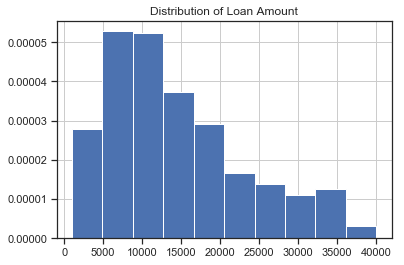

In [27]:
df['funded_amnt'].hist(density = True)
plt.title('Distribution of Loan Amount')

funded amount with the largest population are USD 10,000, 20000 and 15000.

**`dti`**  
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [28]:
df['dti'].describe()

count    366575.000000
mean         18.817953
std          13.384507
min          -1.000000
25%          12.040000
50%          18.020000
75%          24.690000
max         999.000000
Name: dti, dtype: float64

In [29]:
df['dti'].quantile(np.arange(0, 1, 0.099))

0.000    -1.00
0.099     7.32
0.198    10.63
0.297    13.21
0.396    15.55
0.495    17.90
0.594    20.31
0.693    22.97
0.792    26.08
0.891    30.01
0.990    40.92
Name: dti, dtype: float64

In [30]:
(df['dti'] >40).mean()

0.01107004023733206

99% of borrowers having dti less than 40, which is good. Borrowers with dti greater than 40 only make up 1% of population. Notice that the highest dti is 999.

**`term`**  
The number of payments on the loan. Values are in months.

In [31]:
df['term'].value_counts()

 36 months    278968
 60 months     87607
Name: term, dtype: int64

We have either a 36-month or 60-month term. So we will treat it as a categorical feature.

**`purpose`**  
A category provided by the borrower for the loan request. 

In [32]:
purpose = df[['purpose', 'funded_amnt']].groupby('purpose', as_index = False).sum().sort_values('funded_amnt', ascending = False)
total_loan = purpose['funded_amnt'].sum()
purpose['% of Loan Amount'] = purpose['funded_amnt'].map(lambda x: '{:.2f}'.format(100 * x / total_loan)).astype('float')

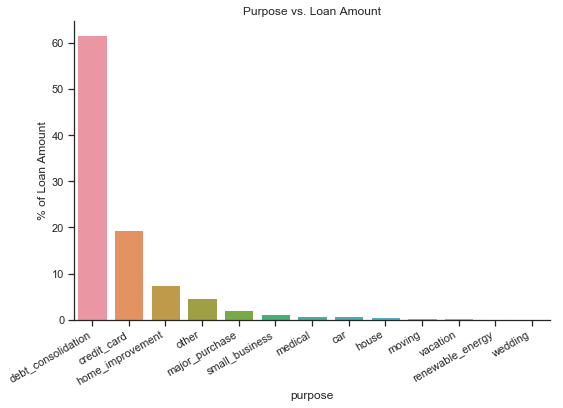

In [33]:
sns.catplot(x = "purpose", y = "% of Loan Amount",kind = 'bar', aspect=1.5, data = purpose).set_xticklabels(rotation=30, ha='right')
plt.title('Purpose vs. Loan Amount')
plt.show()

Over 60% of total funded amount are used to consolidate debt. This is easy to understand because its interest rate used to be lower. Next come to credit card paidofff and home improvement, representing 22.5% and 6% respectively.

**`funded_amnt`**

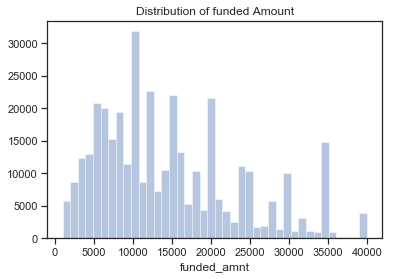

In [34]:
sns.distplot(df['funded_amnt'], kde = False, bins = 40).set_title('Distribution of funded Amount')
plt.show()

The funded amount distribution is right skewed with the greatest amount equal to 40k. Most of loans lie in between 5k and 15k. 
Next we are going to see how loan volume change over year.  


**`credit score vs. loan_status`**

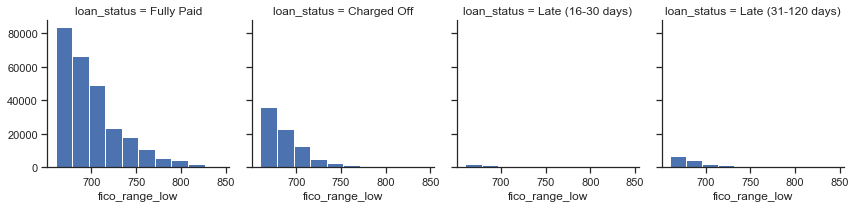

In [35]:
fico_loan = df.loc[:, ['fico_range_low', 'loan_status']]

g = sns.FacetGrid(fico_loan, col = "loan_status")
g = g.map(plt.hist, "fico_range_low")

The most 'charged off' and 'fully paid' both occur in fico between 650 and 700. The distributions for 'charged off" and 'Fully Piad" are similar where the former has a heavier right tail.

**`pub_rec_bankruptcies vs. loan_status`**

In [36]:
df[['pub_rec_bankruptcies', 'loan_status']].groupby('loan_status').sum()

,pub_rec_bankruptcies
loan_status,
Charged Off,14174
Fully Paid,41706
Late (16-30 days),698
Late (31-120 days),2639


There are significantly more public record bankruptcies in the 'charged off' group. But what is interesting is 14174 borrowers with such record were still issued loans. Probably the online lending is less strict than we thought.

**`Correlations between the predictor features and target features`**

Here are the feature pairs with pearson correlation >= 0.6. We will drop out features on `level_1`.

In [100]:
corr = df.corr()
corr = corr.mask(np.tril(np.ones(corr.shape)).astype(np.bool))
corr = corr[abs(corr) >= 0.6].stack().reset_index()
corr.head(20)

,level_0,level_1,0
0,funded_amnt,installment,0.954403
1,delinq_2yrs,num_tl_90g_dpd_24m,0.669535
2,fico_range_low,fico_range_high,1.000000
3,open_acc,total_acc,0.712150
4,pub_rec,pub_rec_bankruptcies,0.645876
5,tot_cur_bal,avg_cur_bal,0.830574
6,tot_cur_bal,tot_hi_cred_lim,0.965410
7,avg_cur_bal,tot_hi_cred_lim,0.783262


In [101]:
# dropping out the features as their information is correlated with other features 

df.drop(columns = ['installment','num_tl_90g_dpd_24m','fico_range_high','total_acc','pub_rec_bankruptcies',
                   'avg_cur_bal','tot_hi_cred_lim'],inplace = True)

## 5. Modeling<a id = '5'></a>

we train logistic regression, Decision Trees, random forest, and ada Boost models and select the best model. 

1 . we will split the data set to training and testing 

2 . loan_status will be treated as target column

### 5.1 Model Training<a id = '5.1'></a>

Since the target feature is imbalanced, accuracy is not a good indicator of model performance. We will take a look at precision, recall and AOC-AUC to evaluate the model.

In [102]:
# Mapping loan statuses into numeric values 

df['loan_status'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off':0,'Late (31-120 days)':0,
                                           'Late (16-30 days)':0})


In [103]:

pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)
df.shape
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 366575 entries, 0 to 118644
Data columns (total 32 columns):
funded_amnt                 366575 non-null int64
term                        366575 non-null object
int_rate                    366575 non-null float64
sub_grade                   366575 non-null object
emp_length                  366575 non-null float64
home_ownership              366575 non-null object
annual_inc                  366575 non-null float64
verification_status         366575 non-null object
loan_status                 366575 non-null int64
purpose                     366575 non-null object
addr_state                  366575 non-null object
dti                         366575 non-null float64
delinq_2yrs                 366575 non-null int64
fico_range_low              366575 non-null int64
open_acc                    366575 non-null int64
pub_rec                     366575 non-null int64
revol_bal                   366575 non-null int64
revol_util               

,funded_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,open_acc,pub_rec,revol_bal,revol_util,initial_list_status,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_tl_op_past_12m,total_bal_ex_mort,total_bc_limit
0,8400,36 months,9.75,B3,2.0,MORTGAGE,66000.0,Not Verified,1,debt_consolidation,GA,13.84,0,670,7,0,11059,78.4,w,Individual,0,0,157051,0,0,2,2,2,2,3,30290,6200
4,20000,36 months,11.99,C1,10.0,MORTGAGE,49000.0,Source Verified,1,debt_consolidation,FL,15.58,1,675,8,0,19014,89.7,w,Individual,0,0,125922,0,0,55,34,5,4,0,29637,13100
5,13625,60 months,15.31,C5,1.0,MORTGAGE,50000.0,Not Verified,1,credit_card,IN,30.41,0,745,21,0,9650,12.4,w,Individual,0,0,204560,0,0,7,7,1,0,3,147437,66900
7,15000,60 months,19.53,D5,1.0,RENT,63890.0,Not Verified,0,debt_consolidation,FL,20.36,0,675,7,0,4307,40.6,w,Individual,0,0,40244,0,0,6,6,0,0,3,40244,10600
9,12000,60 months,13.67,C3,10.0,MORTGAGE,68000.0,Source Verified,0,credit_card,NJ,17.17,0,660,12,0,18424,73.7,w,Individual,0,0,78305,0,0,5,5,0,2,4,78305,7000


In [104]:

# seperating Target variable and applying encoding to categorical features using get dummies 

y = df['loan_status']
X= df.drop('loan_status',axis=1)

X = pd.get_dummies(X,drop_first = True)


In [105]:
# splitting the data set into training and testing and bringing them on to same scale 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)


In [106]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))  

#### 5.1.1 Baseline<a id = '5.1.1'></a>

**`Logistic Regression`**

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix


model=LogisticRegression(random_state = 10)
model.fit(X_train_std,y_train)
y_predict=model.predict(X_test)

print("Confusion Matrix:", confusion_matrix(y_test, y_pred))

print("Accuracy: ", accuracy_score(y_test, y_pred))

print_score(model, X_train_std, y_train, X_test_std, y_test, train=False)


Confusion Matrix: [[12771  7695]
 [38837 14012]]
Accuracy:  0.3653140557866739
Test Result:

accuracy score: 0.7343

Classification Report: 
               precision    recall  f1-score   support

           0       0.58      0.18      0.27     20466
           1       0.75      0.95      0.84     52849

    accuracy                           0.73     73315
   macro avg       0.66      0.56      0.56     73315
weighted avg       0.70      0.73      0.68     73315


Confusion Matrix: 
 [[ 3651 16815]
 [ 2667 50182]]



In [108]:
# Plain Decision Tree classifier 

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_std, y_train)

y_pred = dt_model.predict(X_test_std)

#Confusion matrix for DT

print("Confusion Matrix:", confusion_matrix(y_test, y_pred))

print("Accuracy: ", accuracy_score(y_test, y_pred))

print_score(dt_model, X_train_std, y_train, X_test_std, y_test, train=False)

Confusion Matrix: [[ 7621 12845]
 [13960 38889]]
Accuracy:  0.6343858691945714
Test Result:

accuracy score: 0.6344

Classification Report: 
               precision    recall  f1-score   support

           0       0.35      0.37      0.36     20466
           1       0.75      0.74      0.74     52849

    accuracy                           0.63     73315
   macro avg       0.55      0.55      0.55     73315
weighted avg       0.64      0.63      0.64     73315


Confusion Matrix: 
 [[ 7621 12845]
 [13960 38889]]



In [109]:
# Pruning the DT 

clf_pruned = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train_std, y_train)

## Calculating feature importance

feat_importance = clf_pruned.tree_.compute_feature_importances(normalize=False)

feature_cols = X_train.columns
feat_imp_dict = dict(zip(feature_cols, clf_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.sort_values(by=0, ascending=False)[0:10] #Top 10 features

preds_pruned = clf_pruned.predict(X_test_std)
preds_pruned_train = clf_pruned.predict(X_train_std)

print("Confusion Matrix:", confusion_matrix(y_test, preds_pruned))

print("Accuracy: ", accuracy_score(y_test, preds_pruned))

print_score(clf_pruned, X_train_std, y_train, X_test_std, y_test, train=False)


Confusion Matrix: [[ 3128 17338]
 [ 2961 49888]]
Accuracy:  0.7231262361044807
Test Result:

accuracy score: 0.7231

Classification Report: 
               precision    recall  f1-score   support

           0       0.51      0.15      0.24     20466
           1       0.74      0.94      0.83     52849

    accuracy                           0.72     73315
   macro avg       0.63      0.55      0.53     73315
weighted avg       0.68      0.72      0.66     73315


Confusion Matrix: 
 [[ 3128 17338]
 [ 2961 49888]]



In [116]:
# Random Forest Model training 
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(X_train_std, y_train)


pred_RF = rfcl.predict(X_test_std)

print_score(rfcl, X_train_std, y_train, X_test_std, y_test, train=False)


Test Result:

accuracy score: 0.7295

Classification Report: 
               precision    recall  f1-score   support

           0       0.54      0.20      0.30     20466
           1       0.75      0.93      0.83     52849

    accuracy                           0.73     73315
   macro avg       0.65      0.57      0.56     73315
weighted avg       0.69      0.73      0.68     73315


Confusion Matrix: 
 [[ 4194 16272]
 [ 3559 49290]]



In [110]:
# Ada Boost model Training 

abcl = AdaBoostClassifier( n_estimators= 200, learning_rate=0.1, random_state=22)
abcl = abcl.fit(X_train_std, y_train)
pred_AB =abcl.predict(X_test_std)

print_score(abcl, X_train_std, y_train, X_test_std, y_test, train=False)

Test Result:

accuracy score: 0.7325

Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.13      0.21     20466
           1       0.74      0.97      0.84     52849

    accuracy                           0.73     73315
   macro avg       0.67      0.55      0.52     73315
weighted avg       0.70      0.73      0.66     73315


Confusion Matrix: 
 [[ 2622 17844]
 [ 1767 51082]]



In [111]:
# Bagging model training 

bgcl = BaggingClassifier(n_estimators=100, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(X_train_std, y_train)

pred_BG =bgcl.predict(X_test_std)

print_score(bgcl, X_train_std, y_train, X_test_std, y_test, train=False)


Test Result:

accuracy score: 0.7304

Classification Report: 
               precision    recall  f1-score   support

           0       0.54      0.22      0.31     20466
           1       0.75      0.93      0.83     52849

    accuracy                           0.73     73315
   macro avg       0.65      0.57      0.57     73315
weighted avg       0.70      0.73      0.69     73315


Confusion Matrix: 
 [[ 4484 15982]
 [ 3782 49067]]



In [117]:
# Defining the variables to calculate ROC


pred_bag1 = bgcl.predict_proba(X_test_std)[:, 1]
pred_ada1 = abcl.predict_proba(X_test_std)[:, 1]
pred_RF1 = rfcl.predict_proba(X_test_std)[:, 1]


bag_fpr, bag_tpr, bag_threshold = roc_curve(y_test, pred_bag1)
ada_fpr, ada_tpr, ada_threshold = roc_curve(y_test, pred_ada1)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, pred_RF1)


print('bagging Classifier Score: ', roc_auc_score(y_test, pred_bag1))
print('ada boost Classifier: ', roc_auc_score(y_test, pred_ada1))
print('Random Forest Classifier: ', roc_auc_score(y_test, pred_RF1))


bagging Classifier Score:  0.6986982467063467
ada boost Classifier:  0.7059684575044336
Random Forest Classifier:  0.6945809657626733


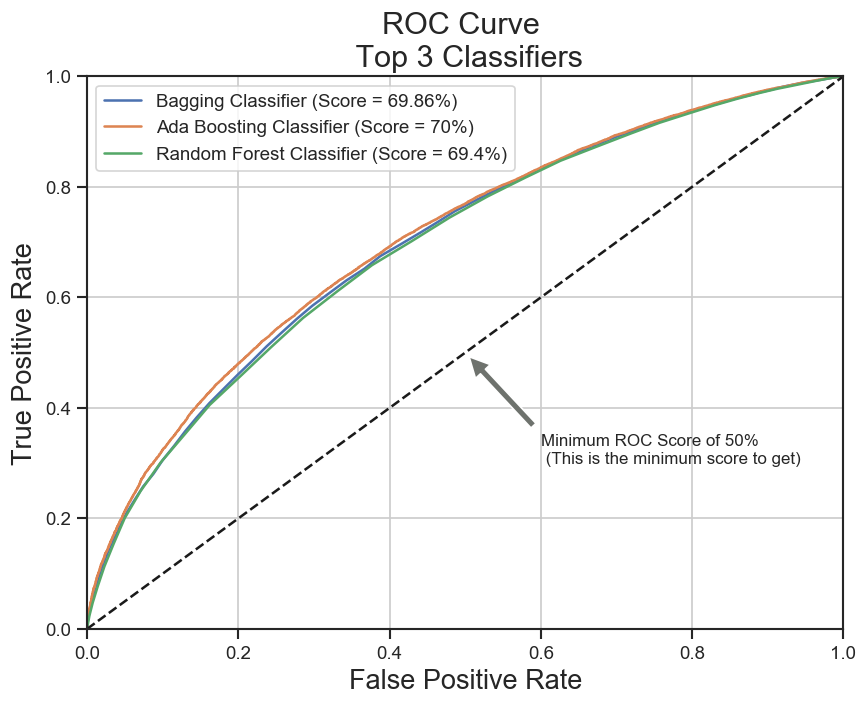

In [118]:
def graph_roc_curve_multiple(bag_fpr, bag_tpr, ada_fpr, ada_tpr,rf_fpr,rf_tpr):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    #plt.plot(grd_fpr, grd_tpr, label='Gradient Boosting Classifier (Score = 79.59%)')
    plt.plot(bag_fpr, bag_tpr, label='Bagging Classifier (Score = 69.86%)')
    plt.plot(ada_fpr, ada_tpr, label='Ada Boosting Classifier (Score = 70%)')
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (Score = 69.4%)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    plt.grid(True)
    
graph_roc_curve_multiple(bag_fpr, bag_tpr, ada_fpr, ada_tpr,rf_fpr,rf_tpr)
plt.show()

* Positive (0): Fully Paid
* Negative (1): CHarged off 
* Precision is defined as `True Positive/(True Positive + False Positive)`.
* Recall is defined as `True Positive/(True Positive + False Negative)`.

here true positive is all the cursotmer who are fully paid and labelled correct and false negative are 
customers who are tagged as not fully paid off that actually paid off , in this case investor may loose a potential opportunity to invest in some one who will fully pay 

and also by considering FPR : `False Positive/(False Positive + True Negative)`.
 is where potential bad 
customers predicted as fully paid even though they are charged off , in this case investor may 
wrongly invest in some one who may not fully pay 



# 6 . Improvements and suggestions 

In [ ]:
# we can apply the Feature selection to select only relevant Features and Also we can apply PCA
#for dimensionality Reduction 
# feature selection using LASSO

train_df_X_Norm = sc.fit_transform(X)

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"))
embeded_lr_selector.fit(train_df_X_Norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')



In [ ]:
# I have applied Grid Search As well but due to computational limitations of my laptop i was not 
# able to properly train it , below is the code to trian using Grid Search 

from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state=0),
                 param_grid = [{'max_depth':[1,2,3,4,5,6,7]}],
                 scoring = 'accuracy',
                 cv=2)

gs = gs.fit(X_train_std,y_train)

print(gs.best_score_)
print(gs.best_params_)


In [112]:
# additionally we could apply different advanced boositng techniques like XG Boost , Light Boost ,
# cat Boost and pipe lines to clean up the coding part 
# another interesting thing we can do is apply Neural netwrok regressor as well 